# Jet Compression using an Autoencoder

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from my_nn_modules import AE_big, get_data, fit

import my_matplotlib_style as ms
mpl.rc_file('../my_matplotlib_rcparams')

In [2]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


## Loading and preparing the data

In [3]:
# Load data
train = pd.read_pickle('processed_data/train.pkl')
test = pd.read_pickle('processed_data/test.pkl')

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


## Normalizing and splitting into train and test datasets

In [4]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

## Training

In [5]:
bs = 64  # batch size
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
loss_func = nn.MSELoss()

In [6]:
n_features = len(train.loc[0])
model_big = AE_big(n_features=n_features)

In [7]:
# Training
epochs_list = [7, 5, 3, 2, 2]
lrs = [1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
for ii, epochs in enumerate(epochs_list):
    print('Setting learning rate to %.1e' % lrs[ii])
    opt = optim.Adam(model_big.parameters(), lr=lrs[ii])
    fit(epochs, model_big, loss_func, opt, train_dl, valid_dl, device)

Setting learning rate to 1.0e-03
Epoch 0: Validation loss = 0.0010193507391755914
Epoch 1: Validation loss = 0.0008629116764276817
Epoch 2: Validation loss = 0.00032616016419667983
Epoch 3: Validation loss = 0.0004421765107852206
Epoch 4: Validation loss = 0.0002388338870147656
Epoch 5: Validation loss = 0.00020258463446580028
Epoch 6: Validation loss = 0.00022768499955563333
Setting learning rate to 3.0e-04
Epoch 0: Validation loss = 0.00013174810730799205
Epoch 1: Validation loss = 0.00014687847395766231
Epoch 2: Validation loss = 9.919012229717138e-05
Epoch 3: Validation loss = 7.94076032583374e-05
Epoch 4: Validation loss = 0.0001031812139298887
Setting learning rate to 1.0e-04
Epoch 0: Validation loss = 0.0010889236872351305
Epoch 1: Validation loss = 6.523566102757496e-05
Epoch 2: Validation loss = 6.326943692902266e-05
Setting learning rate to 3.0e-05
Epoch 0: Validation loss = 7.521736770826317e-05
Epoch 1: Validation loss = 5.785998336343719e-05
Setting learning rate to 1.0e-0

In [8]:
# saving the model for later inference (if training is to be continued another saving method is recommended)
#save_path = './models/AE_big_model_loss48eneg6.pt'
# torch.save(model_big.state_dict(), save_path)
#model_big = AE_big()
#model_big.load_state_dict(torch.load(save_path))
#model_big.eval()

## Evaluation

In [9]:
model_big.eval()

AE_big(
  (en1): Linear(in_features=4, out_features=8, bias=True)
  (en2): Linear(in_features=8, out_features=6, bias=True)
  (en3): Linear(in_features=6, out_features=4, bias=True)
  (en4): Linear(in_features=4, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=4, bias=True)
  (de2): Linear(in_features=4, out_features=6, bias=True)
  (de3): Linear(in_features=6, out_features=8, bias=True)
  (de4): Linear(in_features=8, out_features=4, bias=True)
  (tanh): Tanh()
)

In [10]:
# Print a few tensors, still normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model_big(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.6830, -0.7063,  1.6859,  0.2824], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([ 0.1818, -0.1636, -0.0321, -0.5971], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.3767,  0.6473,  1.3014, -0.5515], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-0.3705, -0.0026,  1.0881, -0.7330], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.7858, -0.3898,  1.1602, -0.7688], grad_fn=<AddBackward0>)
 


In [11]:
# Print a few tensors, now not normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model_big(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([430.8397,  -1.1533,   3.0955, 751.4479])
Out: [430.43878    -1.1481787   3.079619  757.3043   ]
 
Inp: tensor([ 2.4776e+02, -2.8475e-01, -4.7715e-02,  2.5939e+02])
Out: [ 2.4839372e+02 -2.8261593e-01 -4.9683485e-02  2.5709644e+02]
 
Inp: tensor([180.9266,   1.0163,   2.3835, 283.3568])
Out: [180.66904     1.0107679   2.3792737 283.0702   ]
 
Inp: tensor([ 1.8135e+02, -3.3156e-02,  1.9931e+00,  1.8195e+02])
Out: [ 1.8142087e+02 -2.5854368e-02  1.9908172e+00  1.7983981e+02]
 
Inp: tensor([131.5479,  -0.6542,   2.1167, 160.9622])
Out: [131.05911     -0.64346516   2.1220188  159.48145   ]
 


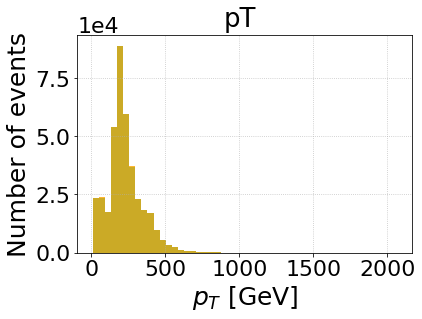

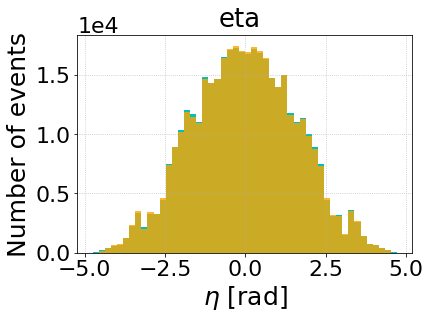

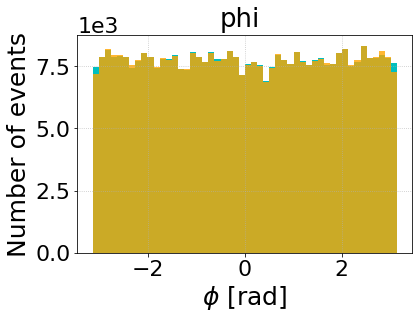

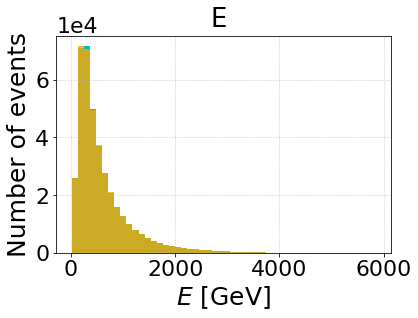

In [12]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
idxs = (0, int(1.9e6))  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model_big(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()

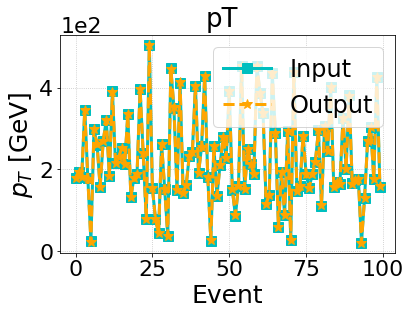

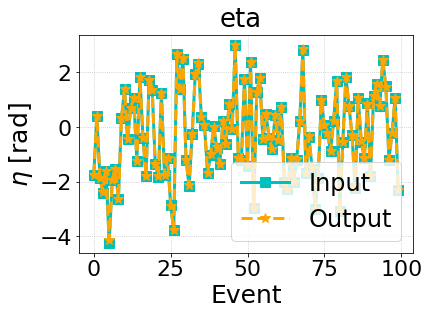

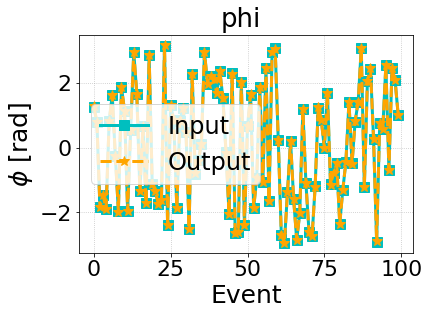

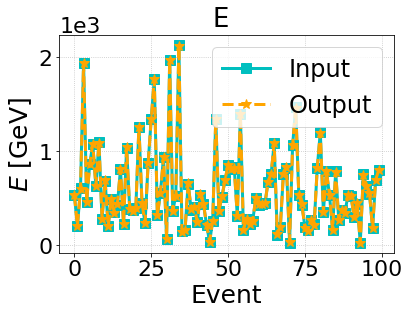

In [13]:
# Plot input on top of output
idxs = (0, 100)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model_big(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()

## Exploring the latent space

In [14]:
# Plot input on top of output
idxs = (0, int(1.9e6))  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model_big.encode(data).detach().numpy()

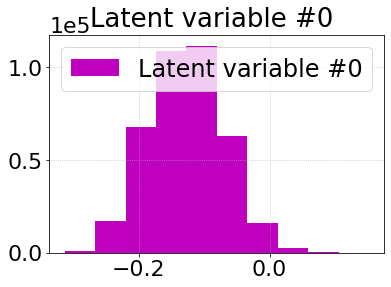

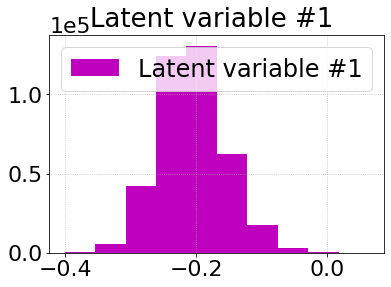

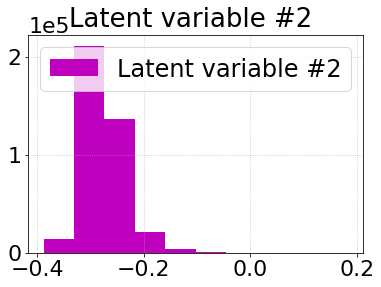

In [15]:
for ii in np.arange(latent.shape[1]):
    plt.figure()
    plt.hist(latent[:,ii], label='Latent variable #%d' % ii, color='m')
    plt.suptitle('Latent variable #%d' % ii)
    plt.legend()
    ms.sciy()

Text(0, 0.5, '$z_3$')

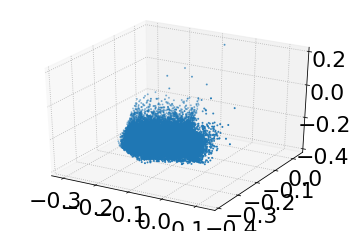

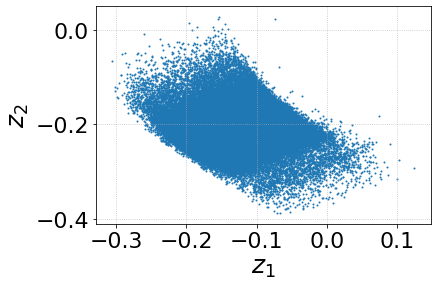

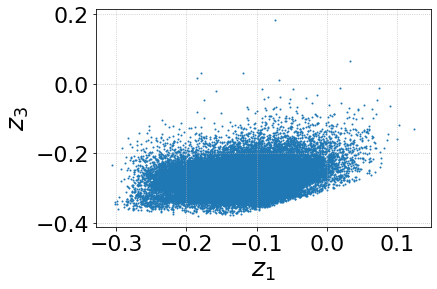

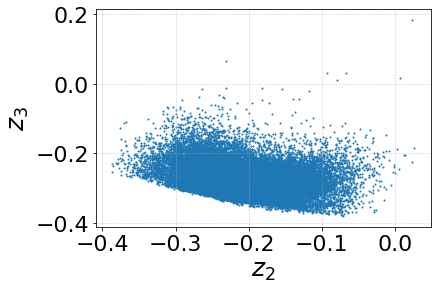

In [16]:
from mpl_toolkits.mplot3d import Axes3D
# Plot latent space variables
idxs = (0, 50000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model_big.encode(data).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent[:, 0], latent[:, 1], latent[:, 2], s=1)

mksz = 1

plt.figure()
plt.scatter(latent[:, 0], latent[:, 1], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')

plt.figure()
plt.scatter(latent[:, 0], latent[:, 2], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_3$')

plt.figure()
plt.scatter(latent[:, 1], latent[:, 2], s=mksz)
plt.xlabel(r'$z_2$')
plt.ylabel(r'$z_3$')

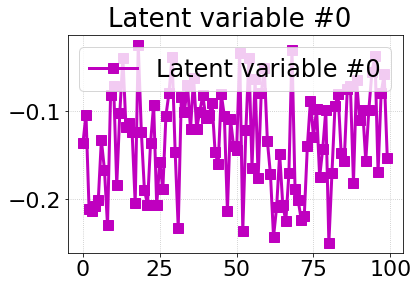

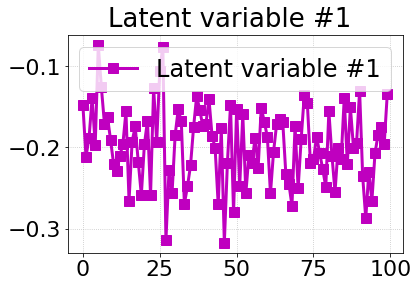

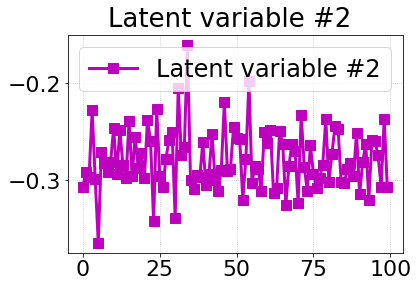

In [17]:
# Plot latent space variables
idxs = (0, 100)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model_big.encode(data).detach().numpy()

for ii in np.arange(latent.shape[1]):
    plt.figure()
    plt.plot(latent[:,ii], marker='s', label='Latent variable #%d' % ii, color='m')
    plt.suptitle('Latent variable #%d' % ii)
    plt.legend()